In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pwd

'/Users/maxwell/Documents/CMU/Courses/Mini 5/ML Capstone/ML-Capstone/Code'

## TOC
- [Ridge](#Ridge)
- [Lasso](#Lasso)
- [RandomForest](#RandomForest)
- [Elastic Net](#ElasticNet)
- [GAM](#GAM)
- [SVR](#SVR)
- [Boosting](#Boosting)

In [6]:
data = pd.read_csv('../data/train_weekly.csv')
test_data = pd.read_csv('../data/test_weekly.csv')
data.Time = pd.to_datetime(data.Time)
test_data.Time = pd.to_datetime(test_data.Time)

In [7]:
data.drop(['Unnamed: 0'], axis = 1, inplace=True)
test_data.drop(['Unnamed: 0'], axis = 1, inplace=True)

In [8]:
data.columns

Index(['Time', 'AM_NetPos', 'FedFunds', '1Y OIS', 'Libor 3 mo', 'Libor 6 mo',
       'Libor 1Y', 'T10Y3M', 'T10Y2Y', 'T10YIE', 'JNK_Price', 'SPX',
       'WILL5000INDFC', 'NASDAQCOM', 'GOLD_price', 'VIX', 'VXVCLS', 'GVZCLS',
       'JPY', 'EUR', 'USDX_Close', 'DTWEXBGS', 'FF_Mkt', 'FF_SMB', 'FF_HML',
       'FF_MOM', 'Signal', 'Lev_NetPos', 'AM_n_L', 'AM_n_S', 'Lev_n_L',
       'Lev_n_S', 'AM_L', 'AM_S', 'Lev_L', 'Lev_S', 'SPY Flows', 'IVV',
       'JNK_Volume', 'Flag'],
      dtype='object')

In [9]:
test_data.columns

Index(['Time', 'AM_NetPos', 'FedFunds', '1Y OIS', 'Libor 3 mo', 'Libor 6 mo',
       'Libor 1Y', 'T10Y3M', 'T10Y2Y', 'T10YIE', 'JNK_Price', 'SPX',
       'WILL5000INDFC', 'NASDAQCOM', 'GOLD_price', 'VIX', 'VXVCLS', 'GVZCLS',
       'JPY', 'EUR', 'USDX_Close', 'DTWEXBGS', 'FF_Mkt', 'FF_SMB', 'FF_HML',
       'FF_MOM', 'Signal', 'Lev_NetPos', 'AM_n_L', 'AM_n_S', 'Lev_n_L',
       'Lev_n_S', 'AM_L', 'AM_S', 'Lev_L', 'Lev_S', 'SPY Flows', 'IVV',
       'JNK_Volume', 'Flag'],
      dtype='object')

<AxesSubplot:>

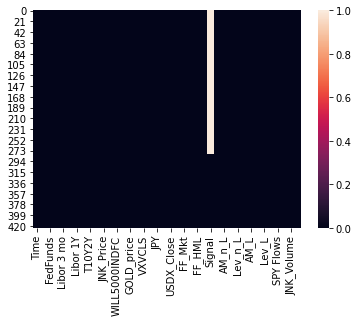

In [10]:
sns.heatmap(data.isnull())

__Lag the CoT Data__

In [11]:
def lag_data(data, lag_variable_lst, rewrite_lst):
    if lag_variable_lst:
        data[['lag_'+v for v in lag_variable_lst]] = data[lag_variable_lst].shift(1)
    if rewrite_lst:
        data[rewrite_lst] = data[rewrite_lst].shift(1)
    return data

In [12]:
def diff_data(data, variable_lst):
    data[['diff_'+v for v in variable_lst]] = data[variable_lst].shift(1)
    return data

In [13]:
lag = ['Libor 3 mo', 'Libor 6 mo', 'Libor 1Y', 'T10Y3M', 'T10Y2Y', 'JPY', 'EUR']
rw = ['AM_n_L', 'AM_n_S', 'Lev_n_L', 'Lev_n_S', 'AM_L', 'AM_S',
       'Lev_L', 'Lev_S','Lev_NetPos']
data = diff_data(lag_data(data, ['AM_NetPos'], rw), lag)
test_data = diff_data(lag_data(test_data, ['AM_NetPos'], rw), lag)

In [14]:
data.drop(['Signal', 'Flag'], axis = 1, inplace = True)
test_data.drop(['Signal', 'Flag'], axis = 1, inplace = True)

In [15]:
data = data.dropna().reset_index(drop = True)
test_data = test_data.dropna().reset_index(drop = True)

In [16]:
p = len(data.columns)
p

46

In [17]:
data.columns

Index(['Time', 'AM_NetPos', 'FedFunds', '1Y OIS', 'Libor 3 mo', 'Libor 6 mo',
       'Libor 1Y', 'T10Y3M', 'T10Y2Y', 'T10YIE', 'JNK_Price', 'SPX',
       'WILL5000INDFC', 'NASDAQCOM', 'GOLD_price', 'VIX', 'VXVCLS', 'GVZCLS',
       'JPY', 'EUR', 'USDX_Close', 'DTWEXBGS', 'FF_Mkt', 'FF_SMB', 'FF_HML',
       'FF_MOM', 'Lev_NetPos', 'AM_n_L', 'AM_n_S', 'Lev_n_L', 'Lev_n_S',
       'AM_L', 'AM_S', 'Lev_L', 'Lev_S', 'SPY Flows', 'IVV', 'JNK_Volume',
       'lag_AM_NetPos', 'diff_Libor 3 mo', 'diff_Libor 6 mo', 'diff_Libor 1Y',
       'diff_T10Y3M', 'diff_T10Y2Y', 'diff_JPY', 'diff_EUR'],
      dtype='object')

## Baseline Model on Positioning 

### Ridge Regression

In [18]:
time_periods = data['Time']
X_train_base = data.iloc[:,2:p-2]
y_train_base = data.iloc[:,1]

X_test_base = test_data.iloc[:,2:p-2]
y_test_base = test_data.iloc[:,1]

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
scaler = StandardScaler()
scaler.fit(X_train_base)
X_train_std_base = scaler.transform(X_train_base)
X_test_std_base = scaler.transform(X_test_base)

In [20]:
from sklearn.linear_model import Ridge, RidgeCV
ridge_base = RidgeCV(alphas = np.linspace(0.1,1,100))
ridge_base.fit(X_train_std_base, y_train_base)

RidgeCV(alphas=array([0.1       , 0.10909091, 0.11818182, 0.12727273, 0.13636364,
       0.14545455, 0.15454545, 0.16363636, 0.17272727, 0.18181818,
       0.19090909, 0.2       , 0.20909091, 0.21818182, 0.22727273,
       0.23636364, 0.24545455, 0.25454545, 0.26363636, 0.27272727,
       0.28181818, 0.29090909, 0.3       , 0.30909091, 0.31818182,
       0.32727273, 0.33636364, 0.34545455, 0.35454545, 0.36363636,
       0.37272727, 0.381818...
       0.69090909, 0.7       , 0.70909091, 0.71818182, 0.72727273,
       0.73636364, 0.74545455, 0.75454545, 0.76363636, 0.77272727,
       0.78181818, 0.79090909, 0.8       , 0.80909091, 0.81818182,
       0.82727273, 0.83636364, 0.84545455, 0.85454545, 0.86363636,
       0.87272727, 0.88181818, 0.89090909, 0.9       , 0.90909091,
       0.91818182, 0.92727273, 0.93636364, 0.94545455, 0.95454545,
       0.96363636, 0.97272727, 0.98181818, 0.99090909, 1.        ]))

In [21]:
ridge_base.alpha_

0.1272727272727273

In [22]:
res_before2020_base = pd.DataFrame(index = ['Ridge'], columns = ['MSE', 'MAE'])
res_2020_base = pd.DataFrame(index = ['Ridge'], columns = ['MSE', 'MAE'])

In [23]:
ind_year2020_base = np.where(test_data['Time'] > "2020-01-01")[0][0]

In [24]:
res_before2020_base.loc['Ridge', 'MSE'] = mean_squared_error(y_test_base[:ind_year2020_base], ridge_base.predict(X_test_std_base[:ind_year2020_base,:]))
res_before2020_base.loc['Ridge', 'MAE'] = mean_absolute_error(y_test_base[:ind_year2020_base], ridge_base.predict(X_test_std_base[:ind_year2020_base,:]))

In [25]:
res_2020_base.loc['Ridge', 'MSE'] = mean_squared_error(y_test_base[ind_year2020_base:], ridge_base.predict(X_test_std_base[ind_year2020_base:,:]))
res_2020_base.loc['Ridge', 'MAE'] = mean_absolute_error(y_test_base[ind_year2020_base:], ridge_base.predict(X_test_std_base[ind_year2020_base:,:]))

In [26]:
res_before2020_base

,MSE,MAE
Ridge,3.54622e+08,15122.4


In [27]:
res_2020_base

,MSE,MAE
Ridge,4.63477e+08,19419.2


## Study Positioning Dynamics

In [28]:
data['dNetPos'] = data['AM_NetPos'].diff()
test_data['dNetPos'] = test_data['AM_NetPos'].diff()

In [29]:
data = data.dropna().reset_index(drop = True)
test_data = test_data.dropna().reset_index(drop = True)

In [30]:
data.columns

Index(['Time', 'AM_NetPos', 'FedFunds', '1Y OIS', 'Libor 3 mo', 'Libor 6 mo',
       'Libor 1Y', 'T10Y3M', 'T10Y2Y', 'T10YIE', 'JNK_Price', 'SPX',
       'WILL5000INDFC', 'NASDAQCOM', 'GOLD_price', 'VIX', 'VXVCLS', 'GVZCLS',
       'JPY', 'EUR', 'USDX_Close', 'DTWEXBGS', 'FF_Mkt', 'FF_SMB', 'FF_HML',
       'FF_MOM', 'Lev_NetPos', 'AM_n_L', 'AM_n_S', 'Lev_n_L', 'Lev_n_S',
       'AM_L', 'AM_S', 'Lev_L', 'Lev_S', 'SPY Flows', 'IVV', 'JNK_Volume',
       'lag_AM_NetPos', 'diff_Libor 3 mo', 'diff_Libor 6 mo', 'diff_Libor 1Y',
       'diff_T10Y3M', 'diff_T10Y2Y', 'diff_JPY', 'diff_EUR', 'dNetPos'],
      dtype='object')

In [31]:
p = len(data.columns)
p

47

In [32]:
# For training purpose
time_periods = data['Time']
X_train = data.iloc[:,2:p-1]
y_train = data.iloc[:,-1]

X_test = test_data.iloc[:,2:p-1]
y_test = test_data.iloc[:,-1]

In [33]:
X_train.columns

Index(['FedFunds', '1Y OIS', 'Libor 3 mo', 'Libor 6 mo', 'Libor 1Y', 'T10Y3M',
       'T10Y2Y', 'T10YIE', 'JNK_Price', 'SPX', 'WILL5000INDFC', 'NASDAQCOM',
       'GOLD_price', 'VIX', 'VXVCLS', 'GVZCLS', 'JPY', 'EUR', 'USDX_Close',
       'DTWEXBGS', 'FF_Mkt', 'FF_SMB', 'FF_HML', 'FF_MOM', 'Lev_NetPos',
       'AM_n_L', 'AM_n_S', 'Lev_n_L', 'Lev_n_S', 'AM_L', 'AM_S', 'Lev_L',
       'Lev_S', 'SPY Flows', 'IVV', 'JNK_Volume', 'lag_AM_NetPos',
       'diff_Libor 3 mo', 'diff_Libor 6 mo', 'diff_Libor 1Y', 'diff_T10Y3M',
       'diff_T10Y2Y', 'diff_JPY', 'diff_EUR'],
      dtype='object')

In [34]:
y_train.head()

0   -17663.0
1    -1699.0
2    23534.0
3    -4359.0
4     -346.0
Name: dNetPos, dtype: float64

In [35]:
data.columns

Index(['Time', 'AM_NetPos', 'FedFunds', '1Y OIS', 'Libor 3 mo', 'Libor 6 mo',
       'Libor 1Y', 'T10Y3M', 'T10Y2Y', 'T10YIE', 'JNK_Price', 'SPX',
       'WILL5000INDFC', 'NASDAQCOM', 'GOLD_price', 'VIX', 'VXVCLS', 'GVZCLS',
       'JPY', 'EUR', 'USDX_Close', 'DTWEXBGS', 'FF_Mkt', 'FF_SMB', 'FF_HML',
       'FF_MOM', 'Lev_NetPos', 'AM_n_L', 'AM_n_S', 'Lev_n_L', 'Lev_n_S',
       'AM_L', 'AM_S', 'Lev_L', 'Lev_S', 'SPY Flows', 'IVV', 'JNK_Volume',
       'lag_AM_NetPos', 'diff_Libor 3 mo', 'diff_Libor 6 mo', 'diff_Libor 1Y',
       'diff_T10Y3M', 'diff_T10Y2Y', 'diff_JPY', 'diff_EUR', 'dNetPos'],
      dtype='object')

### Modeling

For starters, we want to try some basic regression-based model: ridge, lasso, GAM.

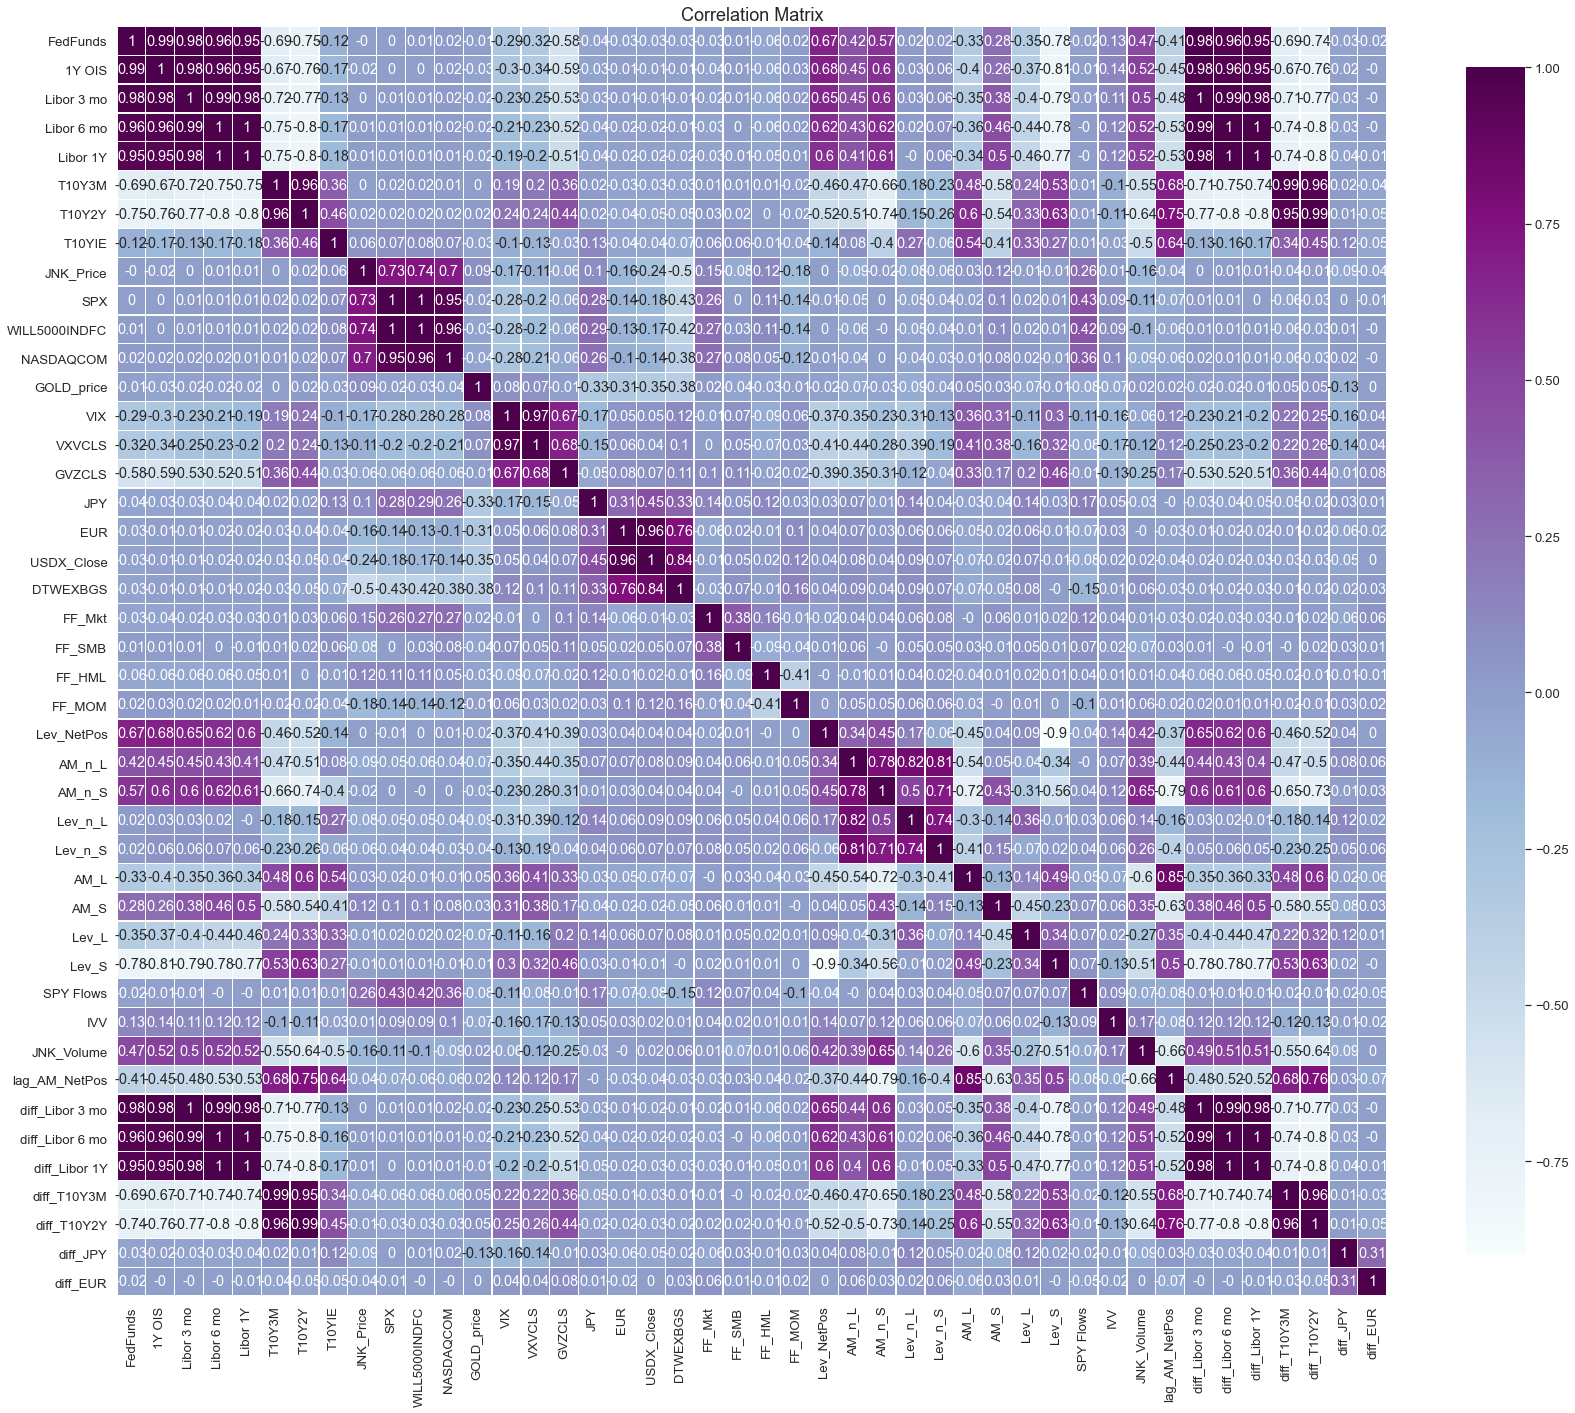

In [36]:
sns.set(font_scale = 1.2)
f, ax = plt.subplots(figsize=(24, 24))
ax = sns.heatmap(np.around(X_train.corr(),2), square=True,linewidths=.3,annot=True,cbar_kws={"shrink": .7}, cmap="BuPu")
plt.tight_layout()
plt.title('Correlation Matrix',size=18)
plt.show()

In [37]:
def tsplot(y, lags=None, figsize = (10,8), style = 'bmh',title='Time Series of Log Ret'):
    import statsmodels.tsa.api as smt
    import statsmodels.api as sm
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan = 2)
        acf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (1,0))
        y.plot(ax = ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags = lags, ax=acf_ax,alpha = 0.05)
        sm.qqplot(y, line = 's', ax=qq_ax)
        qq_ax.set_title('QQ PLot')
        plt.tight_layout()

#### Standardization

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [39]:
res_before2020 = pd.DataFrame(index = ['Ridge', 'Lasso', 'Random Forest'], columns = ['MSE', 'MAE'])
res_2020 = pd.DataFrame(index = ['Ridge', 'Lasso', 'Random Forest'], columns = ['MSE', 'MAE'])

#### Rolling Test Machine

In [40]:
ind_year2020 = np.where(test_data['Time'] > "2020-01-01")[0][0]

#### Ridge

In [41]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [42]:
tscv = TimeSeriesSplit(n_splits = 5)

In [43]:
ridge = RidgeCV(alphas = np.logspace(0.1,2,50), cv = tscv)
ridge.fit(X_train_std, y_train)

RidgeCV(alphas=array([  1.25892541,   1.37649776,   1.50505032,   1.64560853,
         1.79929362,   1.96733152,   2.15106266,   2.35195264,
         2.57160393,   2.8117687 ,   3.0743627 ,   3.36148062,
         3.67541279,   4.01866341,   4.39397056,   4.80432804,
         5.25300922,   5.74359321,   6.27999335,   6.86648845,
         7.50775694,   8.20891416,   8.97555318,   9.81378942,
        10.73030941,  11.73242415,  12.82812743,  14.02615957,
        15.33607719,  16.76832937,  18.33434107,  20.04660423,
        21.91877742,  23.96579481,  26.20398529,  28.6512027 ,
        31.32696828,  34.25262639,  37.45151475,  40.94915062,
        44.77343434,  48.95487189,  53.52681823,  58.52574339,
        63.99152336,  69.96775821,  76.50211983,  83.64673228,
        91.4585875 , 100.        ]),
        cv=TimeSeriesSplit(max_train_size=None, n_splits=5))

In [44]:
ridge.alpha_

76.502119832752

In [45]:
res_before2020.loc['Ridge', 'MSE'] = mean_squared_error(y_test[:ind_year2020], ridge.predict(X_test_std[:ind_year2020,:]))
res_before2020.loc['Ridge', 'MAE'] = mean_absolute_error(y_test[:ind_year2020], ridge.predict(X_test_std[:ind_year2020,:]))

In [46]:
res_2020.loc['Ridge', 'MSE'] = mean_squared_error(y_test[ind_year2020:], ridge.predict(X_test_std[ind_year2020:,:]))
res_2020.loc['Ridge', 'MAE'] = mean_absolute_error(y_test[ind_year2020:], ridge.predict(X_test_std[ind_year2020:,:]))

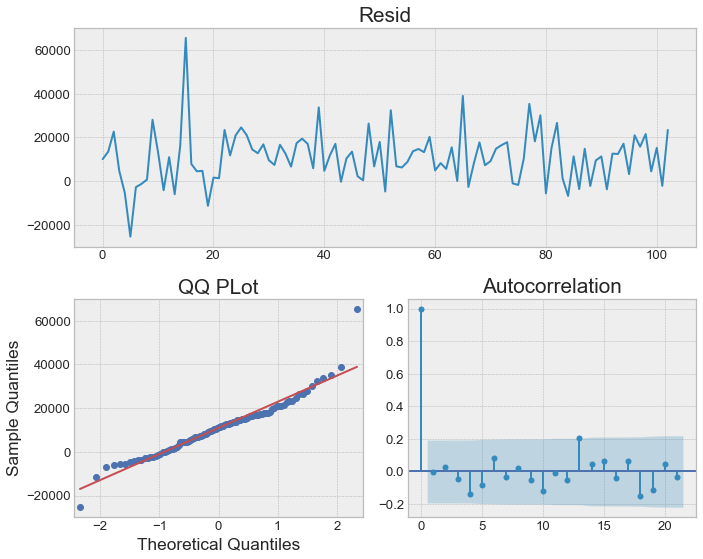

In [47]:
tsplot(y_test - ridge.predict(X_test_std), title = 'Resid')

#### Lasso

In [48]:
lasso = LassoCV(max_iter = 100000, cv = tscv)
lasso.fit(X_train_std, y_train)

LassoCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5), max_iter=100000)

In [49]:
np.log(lasso.alpha_)

6.159307112657825

In [50]:
alpha_range = lasso.alphas_
mse_values = lasso.mse_path_.mean(axis = 1)
sd_values = lasso.mse_path_.std(axis = 1)

In [51]:
alpha_min_ind = np.where(np.abs(np.log(alpha_range) - np.log(lasso.alpha_)) < 1e-4)[0]
alpha_1se_ind = len(mse_values) - np.searchsorted(mse_values[::-1], mse_values[alpha_min_ind]+sd_values[alpha_min_ind])
alpha_1se = alpha_range[alpha_1se_ind]

In [52]:
# 1se
from sklearn.linear_model import Lasso
lasso_1se = Lasso(alpha = alpha_1se, max_iter = 10000)
lasso_1se.fit(X_train_std, y_train)

Lasso(alpha=array([3837.46122691]), max_iter=10000)

Test lasso

In [53]:
res_before2020.loc['Lasso', 'MSE'] = mean_squared_error(y_test[:ind_year2020], lasso.predict(X_test_std[:ind_year2020,:]))
res_before2020.loc['Lasso', 'MAE'] = mean_absolute_error(y_test[:ind_year2020], lasso.predict(X_test_std[:ind_year2020,:]))

In [54]:
res_2020.loc['Lasso', 'MSE'] = mean_squared_error(y_test[ind_year2020:], lasso.predict(X_test_std[ind_year2020:,:]))
res_2020.loc['Lasso', 'MAE'] = mean_absolute_error(y_test[ind_year2020:], lasso.predict(X_test_std[ind_year2020:,:]))

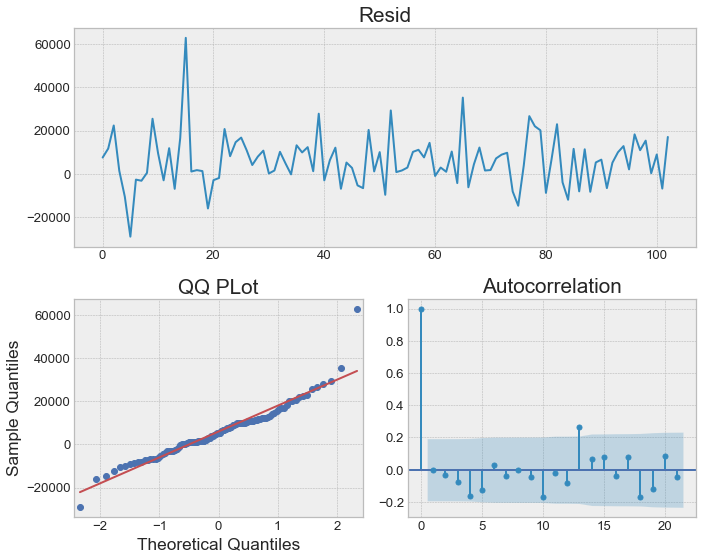

In [55]:
tsplot(y_test - lasso.predict(X_test_std), title = 'Resid')

Test lasso1se

In [56]:
res_before2020.loc['Lasso1se', 'MSE'] = mean_squared_error(y_test[:ind_year2020], lasso_1se.predict(X_test_std[:ind_year2020,:]))
res_before2020.loc['Lasso1se', 'MAE'] = mean_absolute_error(y_test[:ind_year2020], lasso_1se.predict(X_test_std[:ind_year2020,:]))

In [57]:
res_2020.loc['Lasso1se', 'MSE'] = mean_squared_error(y_test[ind_year2020:], lasso_1se.predict(X_test_std[ind_year2020:,:]))
res_2020.loc['Lasso1se', 'MAE'] = mean_absolute_error(y_test[ind_year2020:], lasso_1se.predict(X_test_std[ind_year2020:,:]))

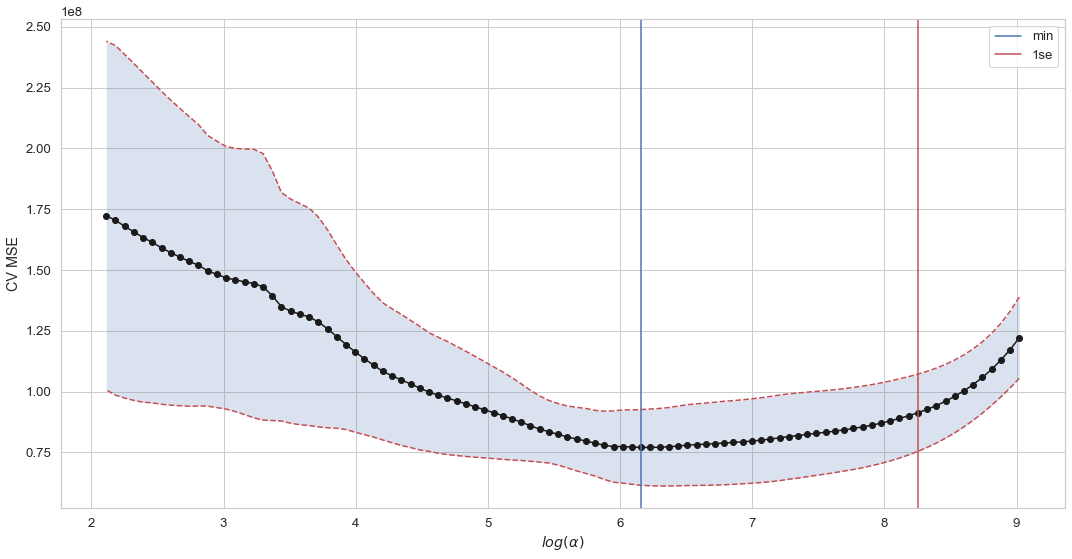

In [58]:
plt.figure(figsize = [18,9])
sns.set_style("whitegrid")
plt.plot(np.log(alpha_range), mse_values ,"ko-")
plt.plot(np.log(alpha_range), mse_values + sd_values,"r--")
plt.plot(np.log(alpha_range), mse_values - sd_values,"r--")
plt.fill_between(np.log(alpha_range),
                mse_values + sd_values,
                mse_values - sd_values, alpha = .2)

plt.axvline(np.log(lasso.alpha_), label = 'min')
plt.axvline(np.log(alpha_1se), label = '1se', color = 'r')
plt.legend()
plt.xlabel(r"$log(\alpha)$")
plt.ylabel("CV MSE");

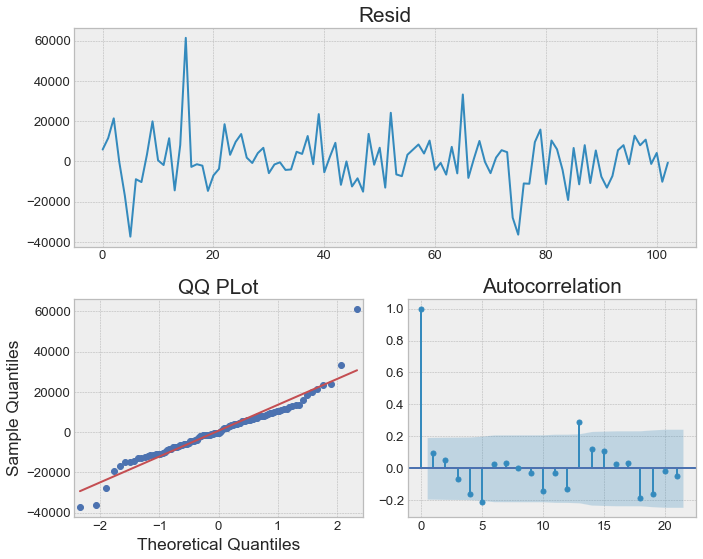

In [59]:
tsplot(y_test - lasso_1se.predict(X_test_std), title = 'Resid')

__Useful variables selected by LASSO__

In [60]:
X_train.columns[np.abs(lasso.coef_ - 0) > 1e-4]

Index(['SPX', 'GOLD_price', 'VIX', 'EUR', 'FF_Mkt', 'FF_SMB', 'AM_S', 'Lev_L',
       'SPY Flows', 'JNK_Volume', 'lag_AM_NetPos', 'diff_EUR'],
      dtype='object')

In [61]:
X_train.columns[np.abs(lasso_1se.coef_ - 0) > 1e-4]

Index(['SPX'], dtype='object')

In [62]:
X_train_std.shape

(422, 44)

In [63]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 20, max_features = 'sqrt')
rf.fit(X_train_std, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=20)

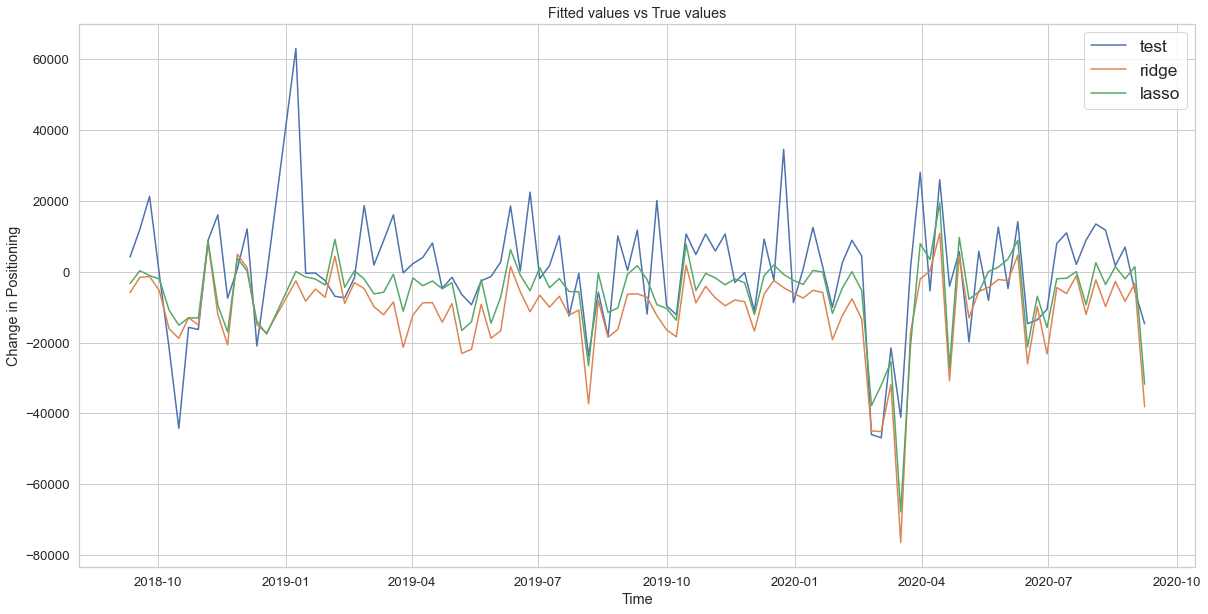

In [64]:
fig = plt.figure(figsize = [20,10])
plt.plot(test_data['Time'], y_test, label = 'test')
plt.plot(test_data['Time'], ridge.predict(X_test_std), label = 'ridge')
plt.plot(test_data['Time'], lasso.predict(X_test_std), label = 'lasso')
plt.xlabel("Time")
plt.ylabel("Change in Positioning")
plt.title('Fitted values vs True values')
plt.legend(fontsize = 'large')

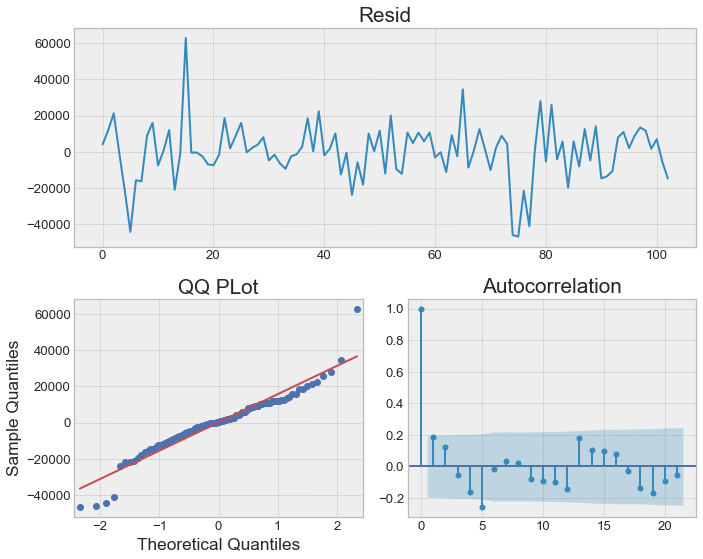

In [65]:
tsplot(y_test, title = 'Resid')

In [66]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(y_test, lags = 10, return_df = True)

,lb_stat,lb_pvalue
1,3.663418,0.055619
2,5.253367,0.072318
3,5.543013,0.136088
4,8.401270,0.077937
5,15.812522,0.007400
6,15.832030,0.014684
7,15.988644,0.025220
8,16.049440,0.041678
9,16.745223,0.052858
10,17.785911,0.058684


#### RandomForest

In [67]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
rf2 = RandomForestRegressor(n_estimators = 30, max_depth = 6, max_features = 'sqrt')
p = X_train_std.shape[1]
param_grids_random = {
    'max_depth': [2, 3, 5, 6, 8, 10],
    'n_estimators': [2, 5, 10, 15, 20, 25, 30, 50, 100]
}

In [68]:
random_grid_search = RandomizedSearchCV(estimator = rf2, param_distributions = param_grids_random, scoring='neg_mean_absolute_error', cv=tscv, n_iter = 40).fit(X_train_std, y_train)

In [69]:
random_grid_search.best_params_

{'n_estimators': 100, 'max_depth': 8}

By random grid search, the best parameter for random forest is {'n_estimators': 50, 'max_depth': 10}

In [70]:
rf2 = RandomForestRegressor(n_estimators = 50, max_depth = 10, max_features = 'sqrt')
X_train_std_df = pd.DataFrame(X_train_std, columns = X_train.columns)
rf2.fit(X_train_std_df, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=50)

In [74]:
import pickle
rf2 = pickle.load(open("tuned_rf_model.pkl", "rb" ))

In [75]:
res_before2020.loc['Random Forest Tuning', 'MSE'] = mean_squared_error(y_test[:ind_year2020], rf2.predict(X_test_std[:ind_year2020,:]))
res_before2020.loc['Random Forest Tuning', 'MAE'] = mean_absolute_error(y_test[:ind_year2020], rf2.predict(X_test_std[:ind_year2020,:]))

In [76]:
res_2020.loc['Random Forest Tuning', 'MSE'] = mean_squared_error(y_test[ind_year2020:], rf2.predict(X_test_std)[ind_year2020:])
res_2020.loc['Random Forest Tuning', 'MAE'] = mean_absolute_error(y_test[ind_year2020:], rf2.predict(X_test_std)[ind_year2020:])

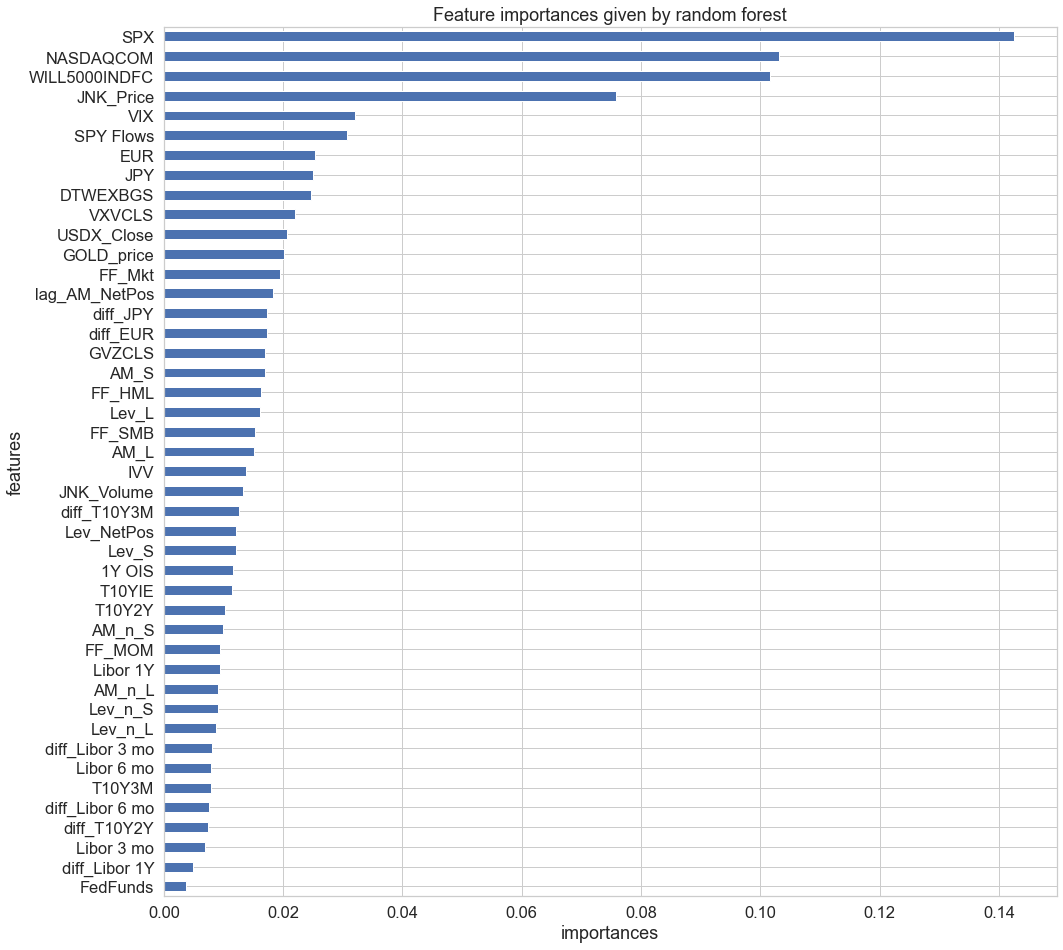

In [77]:
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")
feat_importance = pd.Series(rf2.feature_importances_, index = X_train.columns)
fis = np.argsort(feat_importance)
feat_importance = feat_importance[fis]
fig = plt.figure(figsize = [16,16])
ax = fig.subplots(1,1)
feat_importance.plot(kind = 'barh', ax = ax)
plt.ylabel('features')
plt.xlabel('importances')
plt.title("Feature importances given by random forest")
plt.show()

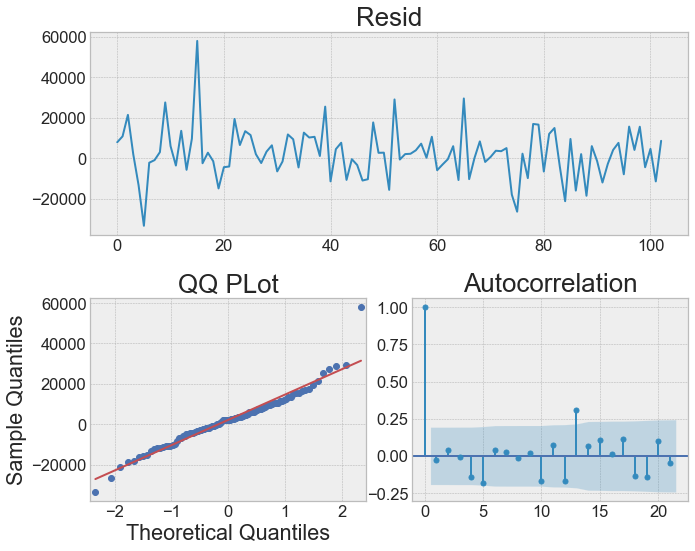

In [80]:
tsplot(y_test - rf2.predict(X_test_std), title = 'Resid')

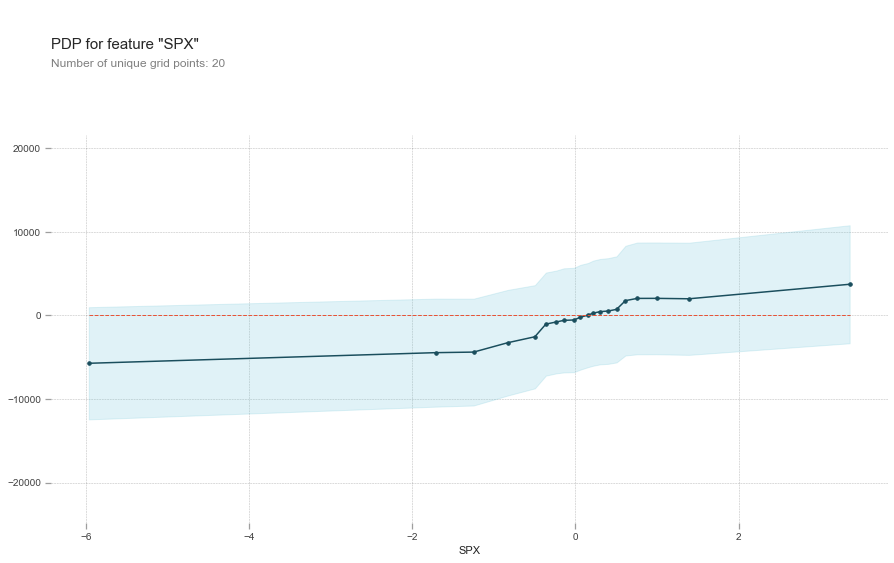

In [81]:
from pdpbox import pdp 
pdp_obj = pdp.pdp_isolate(model=rf2, dataset=X_train_std_df, model_features=list(X_train_std_df.columns), 
                          feature='SPX' , num_grid_points = 20) 
fig, axes = pdp.pdp_plot(pdp_obj, 'SPX', center = False)

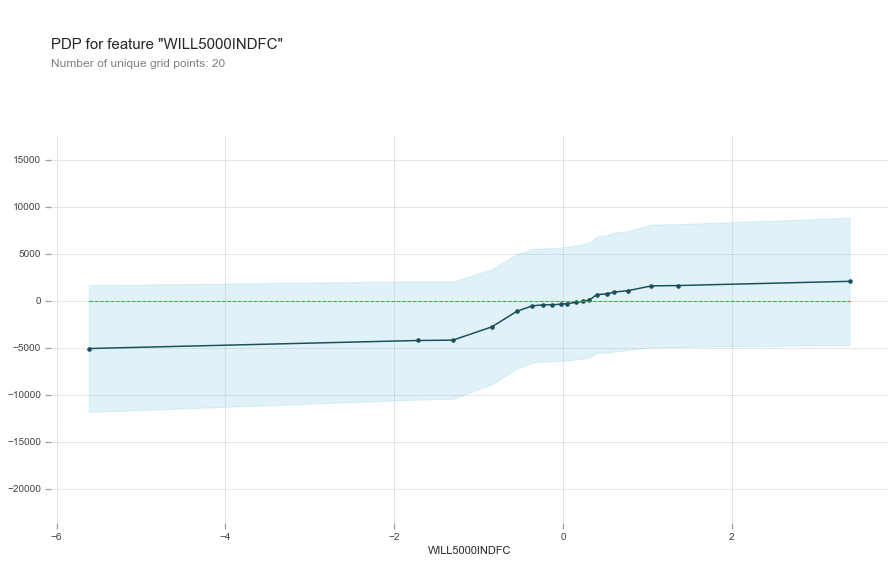

In [82]:
pdp_obj = pdp.pdp_isolate(model=random_grid_search.best_estimator_, dataset=X_train_std_df, model_features=list(X_train.columns), 
                          feature='WILL5000INDFC' , num_grid_points = 20) 
fig, axes = pdp.pdp_plot(pdp_obj, 'WILL5000INDFC', center = False)

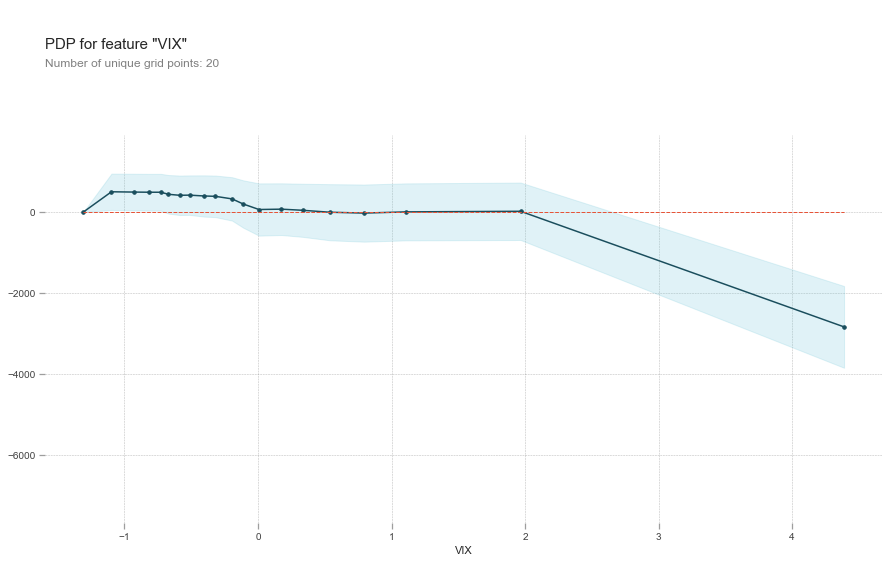

In [83]:
pdp_obj = pdp.pdp_isolate(model=random_grid_search.best_estimator_, dataset=X_train_std_df, model_features=list(X_train.columns), 
                          feature='VIX' , num_grid_points = 20) 
fig, axes = pdp.pdp_plot(pdp_obj, 'VIX')

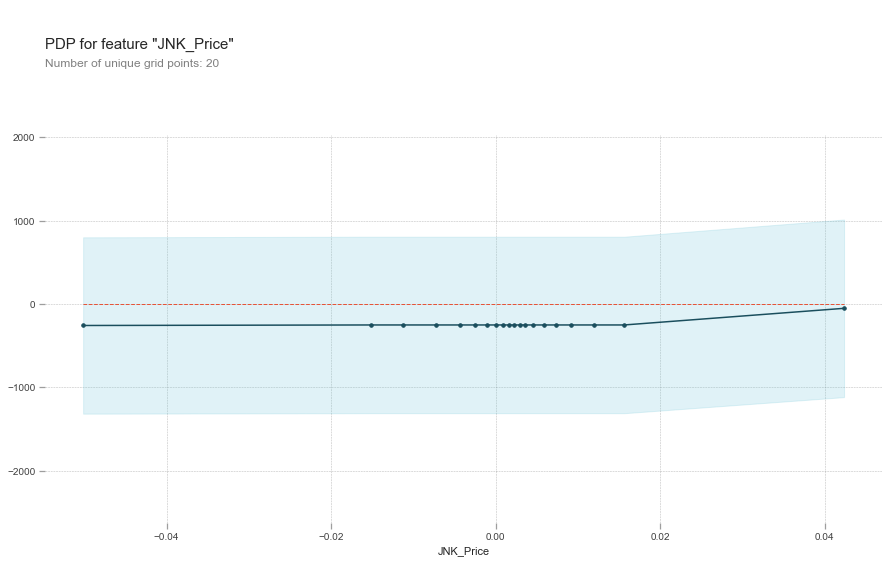

In [84]:
pdp_obj = pdp.pdp_isolate(model=random_grid_search.best_estimator_, dataset=X_train, model_features=list(X_train.columns), 
                          feature='JNK_Price' , num_grid_points = 20) 
fig, axes = pdp.pdp_plot(pdp_obj, 'JNK_Price', center = False)

In [85]:
X_train.columns

Index(['FedFunds', '1Y OIS', 'Libor 3 mo', 'Libor 6 mo', 'Libor 1Y', 'T10Y3M',
       'T10Y2Y', 'T10YIE', 'JNK_Price', 'SPX', 'WILL5000INDFC', 'NASDAQCOM',
       'GOLD_price', 'VIX', 'VXVCLS', 'GVZCLS', 'JPY', 'EUR', 'USDX_Close',
       'DTWEXBGS', 'FF_Mkt', 'FF_SMB', 'FF_HML', 'FF_MOM', 'Lev_NetPos',
       'AM_n_L', 'AM_n_S', 'Lev_n_L', 'Lev_n_S', 'AM_L', 'AM_S', 'Lev_L',
       'Lev_S', 'SPY Flows', 'IVV', 'JNK_Volume', 'lag_AM_NetPos',
       'diff_Libor 3 mo', 'diff_Libor 6 mo', 'diff_Libor 1Y', 'diff_T10Y3M',
       'diff_T10Y2Y', 'diff_JPY', 'diff_EUR'],
      dtype='object')

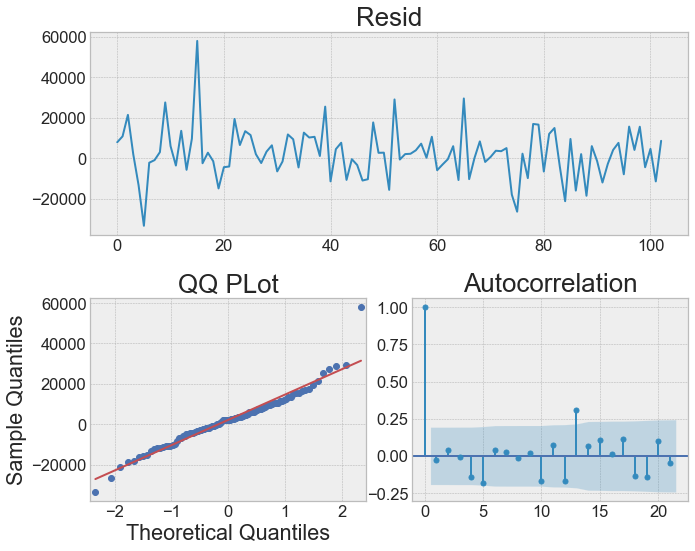

In [86]:
tsplot(y_test - rf2.predict(X_test_std), title = 'Resid')

In [87]:
acorr_ljungbox(y_test - rf2.predict(X_test_std), lags = 10, return_df = True)

,lb_stat,lb_pvalue
1,0.074960,0.784247
2,0.220351,0.895677
3,0.229801,0.972641
4,2.405937,0.661555
5,6.166735,0.290331
6,6.368294,0.383222
7,6.452206,0.488047
8,6.482071,0.593397
9,6.512075,0.687773
10,9.789935,0.459112


Text(0, 0.5, 'Fitted Data')

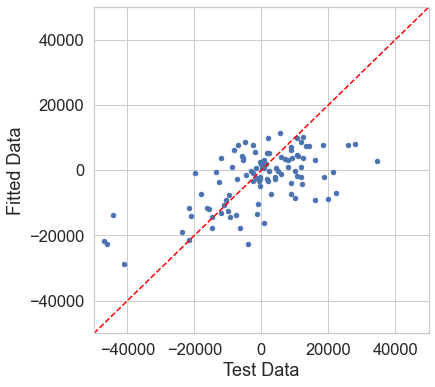

In [88]:
fig = plt.figure(figsize = [6,6])
ax = fig.subplots(1,1)
ax.scatter(y_test, random_grid_search.predict(X_test_std), s = 20)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
ax.set(xlim=(-50000, 50000), ylim=(-50000, 50000))
ax.set_xlabel("Test Data")
ax.set_ylabel("Fitted Data")

We can see our model tends to overestimate the change in positioning data.

#### ElasticNet

In [89]:
from sklearn.linear_model import ElasticNetCV
elastic = ElasticNetCV(l1_ratio = np.linspace(0.4, 1, 10), alphas = np.logspace(1,2,20, base = np.exp(1)), max_iter = 10000, cv= tscv)
elastic.fit(X_train_std, y_train)

ElasticNetCV(alphas=array([2.71828183, 2.86518116, 3.02001911, 3.18322469, 3.35525011,
       3.53657199, 3.72769274, 3.92914189, 4.1414776 , 4.36528819,
       4.60119379, 4.84984802, 5.11193983, 5.38819541, 5.67938019,
       5.98630095, 6.30980809, 6.65079796, 7.01021535, 7.3890561 ]),
             cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             l1_ratio=array([0.4       , 0.46666667, 0.53333333, 0.6       , 0.66666667,
       0.73333333, 0.8       , 0.86666667, 0.93333333, 1.        ]),
             max_iter=10000)

In [90]:
np.log(elastic.alpha_)

1.789473684210526

In [91]:
elastic.l1_ratio_

0.9333333333333333

In [92]:
res_before2020.loc['Elastic Net', 'MSE'] = mean_squared_error(y_test[:ind_year2020], elastic.predict(X_test_std)[:ind_year2020])
res_before2020.loc['Elastic Net', 'MAE'] = mean_absolute_error(y_test[:ind_year2020], elastic.predict(X_test_std)[:ind_year2020])

In [93]:
res_2020.loc['Elastic Net', 'MSE'] = mean_squared_error(y_test[ind_year2020:], elastic.predict(X_test_std)[ind_year2020:])
res_2020.loc['Elastic Net', 'MAE'] = mean_absolute_error(y_test[ind_year2020:], elastic.predict(X_test_std)[ind_year2020:])

In [94]:
X_train.columns[np.abs(elastic.coef_ - 0) > 1e-4]

Index(['FedFunds', '1Y OIS', 'Libor 3 mo', 'Libor 6 mo', 'T10Y3M', 'T10Y2Y',
       'T10YIE', 'JNK_Price', 'SPX', 'WILL5000INDFC', 'NASDAQCOM',
       'GOLD_price', 'VIX', 'VXVCLS', 'GVZCLS', 'JPY', 'EUR', 'USDX_Close',
       'DTWEXBGS', 'FF_Mkt', 'FF_SMB', 'FF_HML', 'FF_MOM', 'Lev_NetPos',
       'AM_n_L', 'AM_n_S', 'Lev_n_L', 'Lev_n_S', 'AM_L', 'AM_S', 'Lev_L',
       'Lev_S', 'SPY Flows', 'IVV', 'JNK_Volume', 'lag_AM_NetPos',
       'diff_Libor 3 mo', 'diff_Libor 6 mo', 'diff_Libor 1Y', 'diff_T10Y3M',
       'diff_T10Y2Y', 'diff_JPY', 'diff_EUR'],
      dtype='object')

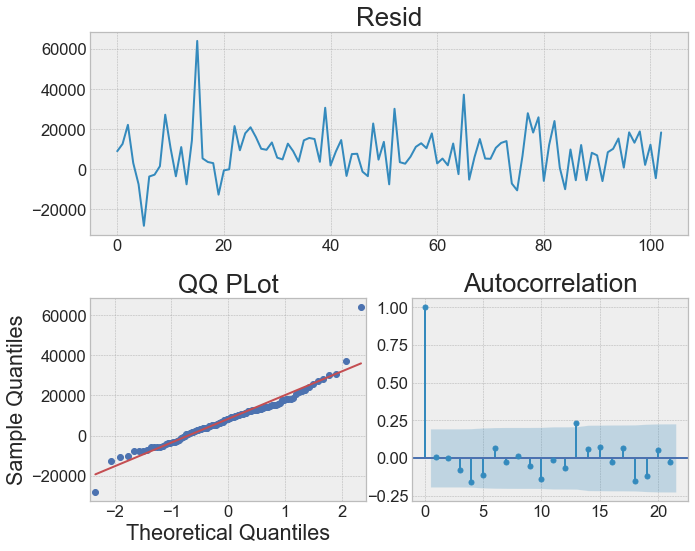

In [95]:
tsplot(y_test - elastic.predict(X_test_std), title = 'Resid')

#### SVR

In [96]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve


In [97]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=tscv,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)}).fit(X_train_std, y_train)

In [98]:
svr.best_params_

{'C': 1000.0, 'gamma': 0.01}

In [99]:
res_before2020.loc['SVR', 'MSE'] = mean_squared_error(y_test[:ind_year2020], svr.predict(X_test_std)[:ind_year2020])
res_before2020.loc['SVR', 'MAE'] = mean_absolute_error(y_test[:ind_year2020], svr.predict(X_test_std)[:ind_year2020])

In [100]:
res_2020.loc['SVR', 'MSE'] = mean_squared_error(y_test[ind_year2020:], svr.predict(X_test_std)[ind_year2020:])
res_2020.loc['SVR', 'MAE'] = mean_absolute_error(y_test[ind_year2020:], svr.predict(X_test_std)[ind_year2020:])

#### GAM

__Examine those important variables__

In [101]:
lasso_pick = X_train.columns[np.abs(lasso.coef_ - 0) > 1e-4]
lasso_pick

Index(['SPX', 'GOLD_price', 'VIX', 'EUR', 'FF_Mkt', 'FF_SMB', 'AM_S', 'Lev_L',
       'SPY Flows', 'JNK_Volume', 'lag_AM_NetPos', 'diff_EUR'],
      dtype='object')

In [102]:
rf_pick = feat_importance[-10:].index
rf_pick

Index(['VXVCLS', 'DTWEXBGS', 'JPY', 'EUR', 'SPY Flows', 'VIX', 'JNK_Price',
       'WILL5000INDFC', 'NASDAQCOM', 'SPX'],
      dtype='object')

In [103]:
common_pick = set(rf_pick).intersection(set(lasso_pick))
common_pick

{'EUR', 'SPX', 'SPY Flows', 'VIX'}

In [104]:
X_train.columns

Index(['FedFunds', '1Y OIS', 'Libor 3 mo', 'Libor 6 mo', 'Libor 1Y', 'T10Y3M',
       'T10Y2Y', 'T10YIE', 'JNK_Price', 'SPX', 'WILL5000INDFC', 'NASDAQCOM',
       'GOLD_price', 'VIX', 'VXVCLS', 'GVZCLS', 'JPY', 'EUR', 'USDX_Close',
       'DTWEXBGS', 'FF_Mkt', 'FF_SMB', 'FF_HML', 'FF_MOM', 'Lev_NetPos',
       'AM_n_L', 'AM_n_S', 'Lev_n_L', 'Lev_n_S', 'AM_L', 'AM_S', 'Lev_L',
       'Lev_S', 'SPY Flows', 'IVV', 'JNK_Volume', 'lag_AM_NetPos',
       'diff_Libor 3 mo', 'diff_Libor 6 mo', 'diff_Libor 1Y', 'diff_T10Y3M',
       'diff_T10Y2Y', 'diff_JPY', 'diff_EUR'],
      dtype='object')

In [105]:
## [ 9, 13, 17, 21, 33, 36]
pickout = np.arange(len(X_train.columns))[np.isin(X_train.columns, np.array([i for i in common_pick]))]
pickout = [ 9, 13, 17, 33]

In [106]:
X_train.columns[pickout]

Index(['SPX', 'VIX', 'EUR', 'SPY Flows'], dtype='object')

In [107]:
res_before2020

,MSE,MAE
Ridge,2.82983e+08,12870.8
Lasso,2.01269e+08,9751.53
Random Forest,NaN,NaN
Lasso1se,1.82682e+08,9277.36
Random Forest Tuning,1.81158e+08,9368.34
Elastic Net,2.3293e+08,11186.3
SVR,2.06738e+08,9865.94


In [108]:
X_train_sel = X_train.iloc[:,pickout]
X_test_sel = X_test.iloc[:,pickout]

__REQUIRES MANUAL CHANGE__

In [109]:
X_train_sel.columns = ['SPX', 'VIX', 'EUR', 'SPYFlows']
X_test_sel.columns = ['SPX', 'VIX', 'EUR', 'SPYFlows']

In [110]:
X_train_sel

,SPX,VIX,EUR,SPYFlows
0,-0.049365,34.13,0.006810,-4424.6870
1,-0.012658,29.65,-0.034690,-10835.6820
2,0.065444,24.56,-0.007702,4171.1670
3,-0.010828,23.93,-0.012112,-1055.8070
4,0.028021,23.19,-0.008926,2873.1330
...,...,...,...,...
417,0.003862,12.41,-0.002225,1915.2560
418,-0.001457,12.83,-0.000342,4568.7080
419,0.014970,10.93,0.007932,-6345.8700
420,-0.006469,13.31,0.022479,1128.0550


In [111]:
r_data_train = pd.concat([X_train_sel, y_train], axis = 1)
r_data_test = pd.concat([X_test_sel, y_test], axis = 1)

In [112]:
import rpy2
%reload_ext rpy2.ipython

In [113]:
%%R -i r_data_train -i r_data_test
head(r_data_train)

           SPX   VIX          EUR   SPYFlows dNetPos
0 -0.049365020 34.13  0.006809977  -4424.687  -17663
1 -0.012657985 29.65 -0.034690322 -10835.682   -1699
2  0.065443651 24.56 -0.007701981   4171.167   23534
3 -0.010827688 23.93 -0.012111800  -1055.807   -4359
4  0.028020822 23.19 -0.008925825   2873.133    -346
5  0.005943403 22.63 -0.017761317   -606.412   -4358


R[write to console]: Loading required package: nlme

R[write to console]: This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.



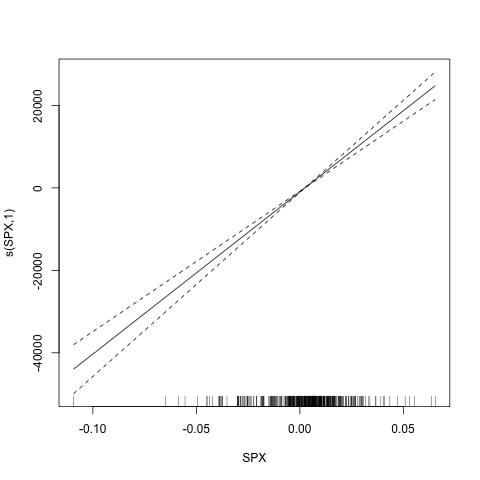

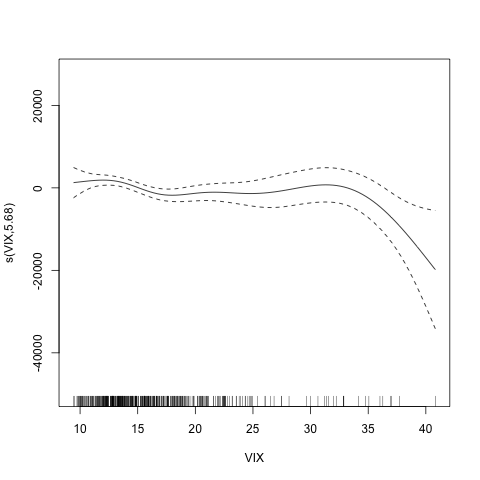

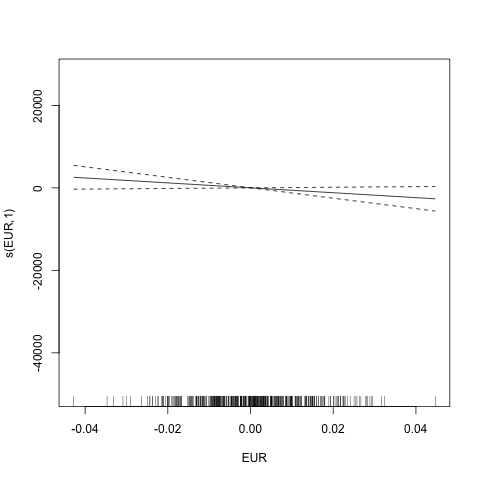

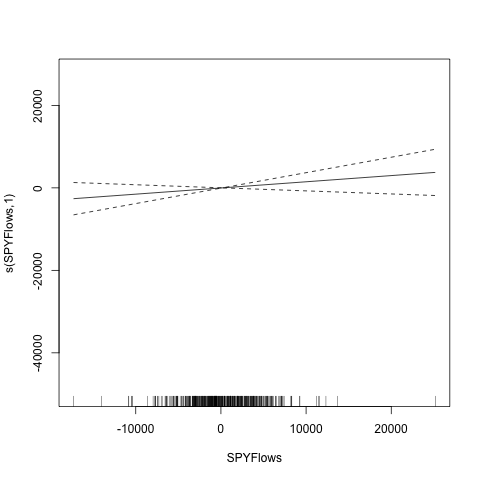

In [114]:
%%R
library(mgcv)
fit = gam(dNetPos ~ s(SPX) + s(VIX) + s(EUR) + s(SPYFlows), data=r_data_train)
plot(fit)

In [115]:
%%R 
summary(fit)


Family: gaussian 
Link function: identity 

Formula:
dNetPos ~ s(SPX) + s(VIX) + s(EUR) + s(SPYFlows)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   -444.5      422.9  -1.051    0.294

Approximate significance of smooth terms:
             edf Ref.df       F p-value    
s(SPX)      1.00    1.0 219.605  <2e-16 ***
s(VIX)      5.68    6.8   2.821  0.0078 ** 
s(EUR)      1.00    1.0   3.163  0.0761 .  
s(SPYFlows) 1.00    1.0   1.789  0.1818    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.488   Deviance explained = 49.8%
GCV = 7.7239e+07  Scale est. = 7.5467e+07  n = 422


In [116]:
%%R -o gam_predict
gam_predict = predict(fit, newdata=r_data_test)

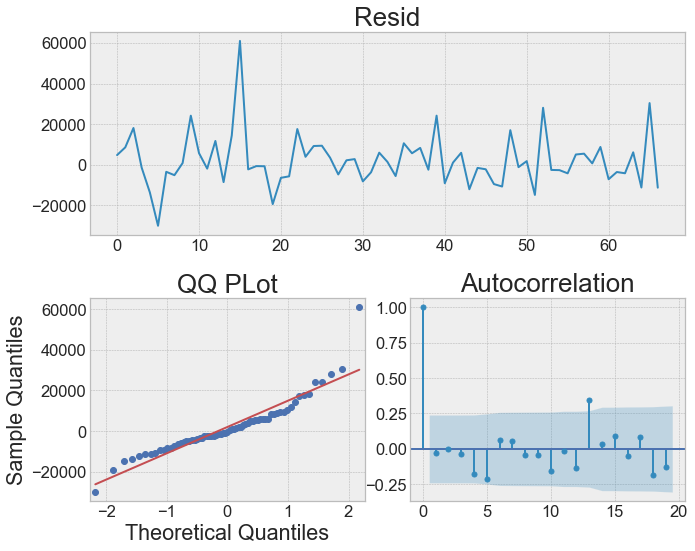

In [117]:
tsplot(y_test[:ind_year2020] - gam_predict[:ind_year2020], title = 'Resid')

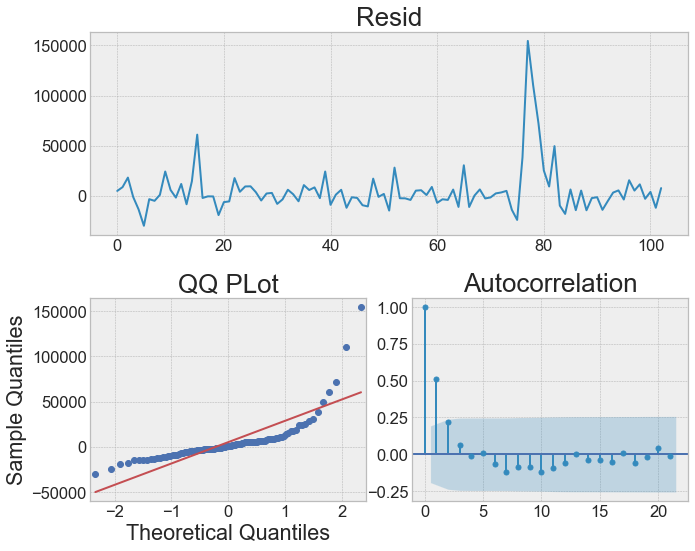

In [118]:
tsplot(y_test - gam_predict, title = 'Resid')

In [119]:
res_before2020.loc['GAM', 'MSE'] = mean_squared_error(y_test[:ind_year2020], gam_predict[:ind_year2020])
res_before2020.loc['GAM', 'MAE'] = mean_absolute_error(y_test[:ind_year2020], gam_predict[:ind_year2020])

In [120]:
res_2020.loc['GAM', 'MSE'] = mean_squared_error(y_test[ind_year2020:], gam_predict[ind_year2020:])
res_2020.loc['GAM', 'MAE'] = mean_absolute_error(y_test[ind_year2020:], gam_predict[ind_year2020:])

In [121]:
res_before2020

,MSE,MAE
Ridge,2.82983e+08,12870.8
Lasso,2.01269e+08,9751.53
Random Forest,NaN,NaN
Lasso1se,1.82682e+08,9277.36
Random Forest Tuning,1.81158e+08,9368.34
Elastic Net,2.3293e+08,11186.3
SVR,2.06738e+08,9865.94
GAM,1.71599e+08,8892.31


In [122]:
res_2020

,MSE,MAE
Ridge,2.25428e+08,12475.9
Lasso,1.39276e+08,10017.2
Random Forest,NaN,NaN
Lasso1se,1.32547e+08,9038.53
Random Forest Tuning,1.23884e+08,9001.24
Elastic Net,1.64053e+08,10980.1
SVR,2.55462e+08,11958.9
GAM,1.34959e+09,18918.1


#### Boosting

In [123]:
from sklearn.ensemble import GradientBoostingRegressor

p_test = {'min_samples_split':[20,50,80],'max_depth':[2,4,6,8],'n_estimators':[20,30,50]}

In [124]:
clf = GridSearchCV(GradientBoostingRegressor(), param_grid = p_test, cv = tscv,scoring='neg_mean_absolute_error')
clf.fit(X_train_sel, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8],
                         'min_samples_split': [20, 50, 80],
                         'n_estimators': [20, 30, 50]},
             scoring='neg_mean_absolute_error')

In [125]:
clf.best_params_

{'max_depth': 2, 'min_samples_split': 50, 'n_estimators': 30}

In [126]:
params = {'n_estimators': 30, 'max_depth': 2, 'min_samples_split': 50,
          'learning_rate': 0.05}
clf = GradientBoostingRegressor(**params).fit(X_train, y_train)

In [127]:
res_before2020.loc['GBM', 'MSE'] = mean_squared_error(y_test[:ind_year2020],clf.predict(X_test_std)[:ind_year2020])
res_before2020.loc['GBM', 'MAE'] = mean_absolute_error(y_test[:ind_year2020], clf.predict(X_test_std)[:ind_year2020])

In [128]:
res_2020.loc['GBM', 'MSE'] = mean_squared_error(y_test[ind_year2020:], clf.predict(X_test_std)[ind_year2020:])
res_2020.loc['GBM', 'MAE'] = mean_absolute_error(y_test[ind_year2020:], clf.predict(X_test_std)[ind_year2020:])

In [129]:
clf2 = GridSearchCV(GradientBoostingRegressor(), param_grid = p_test, cv = tscv,scoring='neg_mean_absolute_error')
clf2.fit(X_train_sel, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8],
                         'min_samples_split': [20, 50, 80],
                         'n_estimators': [20, 30, 50]},
             scoring='neg_mean_absolute_error')

In [130]:
clf2.best_params_

{'max_depth': 2, 'min_samples_split': 50, 'n_estimators': 30}

In [131]:
params = {'n_estimators': 30, 'max_depth': 2, 'min_samples_split': 50,
          'learning_rate': 0.05}
clf2 = GradientBoostingRegressor(**params).fit(X_train_sel, y_train)

In [132]:
res_before2020.loc['GBM after selection', 'MSE'] = mean_squared_error(y_test[:ind_year2020],clf2.predict(X_test_sel)[:ind_year2020])
res_before2020.loc['GBM after selection', 'MAE'] = mean_absolute_error(y_test[:ind_year2020], clf2.predict(X_test_sel)[:ind_year2020])

In [133]:
res_2020.loc['GBM after selection', 'MSE'] = mean_squared_error(y_test[ind_year2020:], clf2.predict(X_test_sel)[ind_year2020:])
res_2020.loc['GBM after selection', 'MAE'] = mean_absolute_error(y_test[ind_year2020:], clf2.predict(X_test_sel)[ind_year2020:])

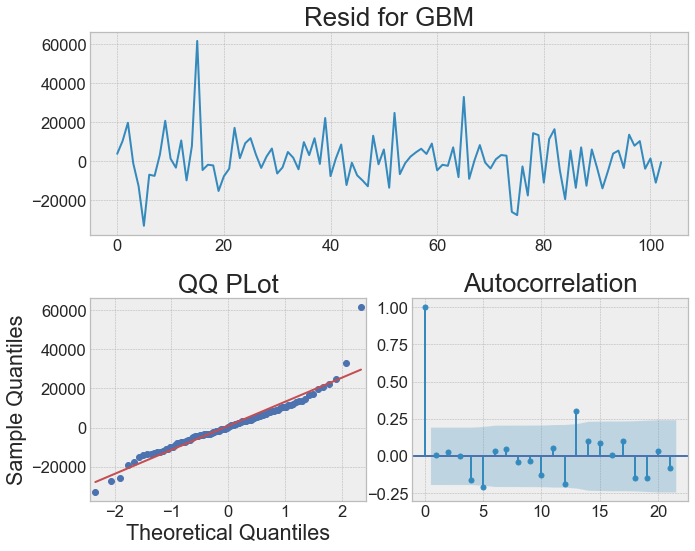

In [134]:
tsplot(y_test - clf2.predict(X_test_sel), title = 'Resid for GBM')

Text(0, 0.5, 'Fitted Data')

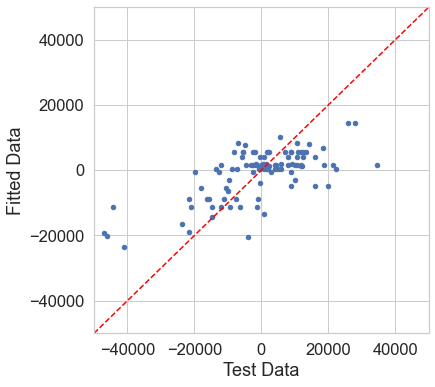

In [135]:
fig = plt.figure(figsize = [6,6])
ax = fig.subplots(1,1)
ax.scatter(y_test, clf2.predict(X_test_sel), s = 20)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
ax.set(xlim=(-50000, 50000), ylim=(-50000, 50000))
ax.set_xlabel("Test Data")
ax.set_ylabel("Fitted Data")

In [136]:
res_before2020 = res_before2020.drop('Random Forest') 

In [137]:
res_before2020

,MSE,MAE
Ridge,2.82983e+08,12870.8
Lasso,2.01269e+08,9751.53
Lasso1se,1.82682e+08,9277.36
Random Forest Tuning,1.81158e+08,9368.34
Elastic Net,2.3293e+08,11186.3
SVR,2.06738e+08,9865.94
GAM,1.71599e+08,8892.31
GBM,3.01699e+08,13217.6
GBM after selection,1.68064e+08,8828.06


In [138]:
res_2020 = res_2020.drop('Random Forest') 
res_2020

,MSE,MAE
Ridge,2.25428e+08,12475.9
Lasso,1.39276e+08,10017.2
Lasso1se,1.32547e+08,9038.53
Random Forest Tuning,1.23884e+08,9001.24
Elastic Net,1.64053e+08,10980.1
SVR,2.55462e+08,11958.9
GAM,1.34959e+09,18918.1
GBM,1.67825e+08,10459.9
GBM after selection,1.21753e+08,8689.44


#### Transfer from delta positioning to positioning

In [141]:
def trans_back(delta, original_df):
    return delta + original_df

In [142]:
X_test.columns

Index(['FedFunds', '1Y OIS', 'Libor 3 mo', 'Libor 6 mo', 'Libor 1Y', 'T10Y3M',
       'T10Y2Y', 'T10YIE', 'JNK_Price', 'SPX', 'WILL5000INDFC', 'NASDAQCOM',
       'GOLD_price', 'VIX', 'VXVCLS', 'GVZCLS', 'JPY', 'EUR', 'USDX_Close',
       'DTWEXBGS', 'FF_Mkt', 'FF_SMB', 'FF_HML', 'FF_MOM', 'Lev_NetPos',
       'AM_n_L', 'AM_n_S', 'Lev_n_L', 'Lev_n_S', 'AM_L', 'AM_S', 'Lev_L',
       'Lev_S', 'SPY Flows', 'IVV', 'JNK_Volume', 'lag_AM_NetPos',
       'diff_Libor 3 mo', 'diff_Libor 6 mo', 'diff_Libor 1Y', 'diff_T10Y3M',
       'diff_T10Y2Y', 'diff_JPY', 'diff_EUR'],
      dtype='object')

In [165]:
predicted_values = pd.DataFrame(index= test_data.Time)
predicted_values['ridge'] = trans_back(ridge.predict(X_test_std), X_test['lag_AM_NetPos']).values
predicted_values['randomforest'] = trans_back(rf2.predict(X_test_std), X_test['lag_AM_NetPos']).values
predicted_values['lasso'] = trans_back(lasso.predict(X_test_std), X_test['lag_AM_NetPos']).values
predicted_values['lasso1se'] = trans_back(lasso_1se.predict(X_test_std), X_test['lag_AM_NetPos']).values
predicted_values['elasticnet'] = trans_back(elastic.predict(X_test_std), X_test['lag_AM_NetPos']).values
predicted_values['svr'] = trans_back(svr.predict(X_test_std), X_test['lag_AM_NetPos']).values
predicted_values['gbm'] = trans_back(clf2.predict(X_test_sel), X_test['lag_AM_NetPos']).values
predicted_values['gam'] = trans_back(gam_predict, X_test['lag_AM_NetPos']).values

In [166]:
predicted_values

,ridge,randomforest,lasso,lasso1se,elasticnet,svr,gbm,gam
Time,,,,,,,,
2018-09-11,110994.863251,113202.100430,113536.060717,115178.624412,112055.877200,115077.645081,117188.796408,116253.630482
2018-09-18,119456.989169,122192.850723,121304.374991,121377.541844,120313.369472,120814.704094,122597.417504,124352.532310
2018-09-25,131572.594066,132842.949105,131859.950590,132851.294113,132065.668998,132424.464135,134499.417504,136098.768309
2018-10-02,148878.501497,151526.366455,152144.924720,153836.813411,150379.349620,152420.897383,154488.796408,154875.796440
2018-10-09,137413.146486,145342.098360,142636.417268,149011.909166,139464.545871,149269.074465,144660.542328,145559.081492
...,...,...,...,...,...,...,...,...
2020-08-11,112580.780190,118599.479203,118785.670256,123341.420725,115253.457535,119877.050090,123788.394238,122770.567495
2020-08-18,131352.564566,140307.181127,135565.305231,137080.846409,133626.361556,133556.353625,139596.276794,138869.472010
2020-08-25,127475.585991,138155.449040,133796.172415,138536.207610,130456.707659,134084.475050,141274.276794,138867.885060


In [399]:
X_test.shape

(103, 44)

In [400]:
rf2.predict(X_test_std).shape

(103,)

In [401]:
X_test['lag_AM_NetPos'].shape

(103,)